In [19]:
import numpy as np
import scipy as sp
import statsmodels.formula.api as smf
import pylab as pl
import pandas as pd
import os
%pylab inline

import urllib3 as urllib
import urllib.request
import geopandas as gp
import choroplethNYC as cp
import requests
import io
from shapely.geometry import Point
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt
from fiona.crs import from_epsg

Populating the interactive namespace from numpy and matplotlib


In [4]:
puidata = os.getenv("PUIDATA")
if puidata is None:
    os.environ["PUIDATA"] = "%s/PUIdata"%os.getenv("HOME")
    puidata = os.getenv("PUIDATA")

In [5]:
!curl https://data.cityofnewyork.us/api/views/rgfe-8y2z/rows.csv?accessType=DOWNLOAD > energy.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4329k    0 4329k    0     0  3162k      0 --:--:--  0:00:01 --:--:-- 3162k      0 --:--:-- --:--:-- --:--:-- 2201k


In [6]:
!mv energy.csv $PUIDATA

In [9]:
energy = pd.read_csv('%s/energy.csv'%os.getenv("PUIDATA"))

In [11]:
energy.head()

,Record Number,BBL,Co-reported BBL Status,BBLs Co-reported,Reported NYC Building Identificaiton Numbers (BINs),Street Number,Street Name,Borough,Postcode,DOF Benchmarking Submission Status,...,DOF Property Floor Area (Buildngs and Parking)(ft2),Primary Property Type - Self Selected,DOF Number of Buildings,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,NTA
0,12086,1.000410e+09,NaN,1000410001,1001007,NaN,NaN,Manhattan,NaN,BBL not valid,...,NaN,Office,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,14354,4.021460e+09,NaN,NaN,NaN,63-10,108 STREET,Queens,11375.0,No Submission Matched to BBL,...,82730.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12150,2.027620e+09,NaN,2027620097,2006460,NaN,NaN,Bronx,NaN,BBL not valid,...,NaN,Multifamily Housing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12590,1.006700e+09,NaN,NaN,NaN,201,11 AVENUE,Manhattan,10001.0,No Submission Matched to BBL,...,440360.0,NaN,1.0,40.749652,-74.006471,4.0,3.0,99.0,1012266.0,Hudson Yards-Chelsea-Flatiron-Union Square ...
4,15591,2.048300e+09,NaN,2048300034,2063117,NaN,NaN,Bronx,NaN,Not on Covered Buildings List,...,NaN,Multifamily Housing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
url = 'https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/mn_mappluto_18v1.zip'

In [16]:
urllib.request.urlretrieve(url, "manpluto.zip")

('manpluto.zip', <http.client.HTTPMessage at 0x1a235ed748>)

In [17]:
!unzip manpluto.zip -d $PUIDATA

Archive:  manpluto.zip
  inflating: /Users/anaemendezmendez/Documents/NYU_PHD/Fall_2018/PUI2018/PUIDATA/PLUTODD18v1.pdf  
  inflating: /Users/anaemendezmendez/Documents/NYU_PHD/Fall_2018/PUI2018/PUIDATA/MN_Dcp_Mappinglot.dbf  
  inflating: /Users/anaemendezmendez/Documents/NYU_PHD/Fall_2018/PUI2018/PUIDATA/MN_Dcp_Mappinglot.prj  
  inflating: /Users/anaemendezmendez/Documents/NYU_PHD/Fall_2018/PUI2018/PUIDATA/MN_Dcp_Mappinglot.sbn  
  inflating: /Users/anaemendezmendez/Documents/NYU_PHD/Fall_2018/PUI2018/PUIDATA/MN_Dcp_Mappinglot.sbx  
  inflating: /Users/anaemendezmendez/Documents/NYU_PHD/Fall_2018/PUI2018/PUIDATA/MN_Dcp_Mappinglot.shp  
  inflating: /Users/anaemendezmendez/Documents/NYU_PHD/Fall_2018/PUI2018/PUIDATA/MN_Dcp_Mappinglot.shp.xml  
  inflating: /Users/anaemendezmendez/Documents/NYU_PHD/Fall_2018/PUI2018/PUIDATA/MN_Dcp_Mappinglot.shx  
  inflating: /Users/anaemendezmendez/Documents/NYU_PHD/Fall_2018/PUI2018/PUIDATA/mn_pluto.dbf  
  inflating: /Users/anaemendezmendez/Docume

In [18]:
!mv manpluto.zip $PUIDATA

In [20]:
building_size = gp.GeoDataFrame.from_file(os.getenv("PUIDATA") + "/MNMapPLUTO.shp")

In [22]:
building_size.head()

,Borough,Block,Lot,CD,CT2010,CB2010,SchoolDist,Council,ZipCode,FireComp,...,APPBBL,APPDate,PLUTOMapID,FIRM07_FLA,PFIRM15_FL,Version,MAPPLUTO_F,SHAPE_area,SHAPE_len,geometry
0,MN,1545,52,108,138,4000,02,5,10028,E022,...,0.000000e+00,None,1,None,None,18V1,0,2867.154705,260.428942,"POLYGON ((997277.2344360352 221816.0936279297,..."
1,MN,723,7501,104,93,6000,02,3,10001,E003,...,1.007230e+09,11/30/2006,1,None,None,18V1,7,10907.639931,417.764545,"POLYGON ((984164.5626220703 211846.0704345703,..."
2,MN,1680,48,111,170,5000,04,8,10029,E091,...,0.000000e+00,None,1,1,1,18V1,0,2665.033424,256.893308,"POLYGON ((1000742.195800781 227910.6640014648,..."
3,MN,1385,32,108,130,2003,02,4,10021,E039,...,0.000000e+00,None,1,None,None,18V1,0,15302.920914,505.033271,"POLYGON ((994007.6885986328 219880.4284057617,..."
4,MN,1197,27,107,169,5000,03,6,10024,E074,...,0.000000e+00,None,1,None,None,18V1,0,4374.612456,295.652483,"POLYGON ((992273.6849975586 224863.4904174805,..."


/anaconda2/envs/py36_geopandas/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pandas.scatter_matrix is deprecated, use pandas.plotting.scatter_matrix instead
  """Entry point for launching an IPython kernel.


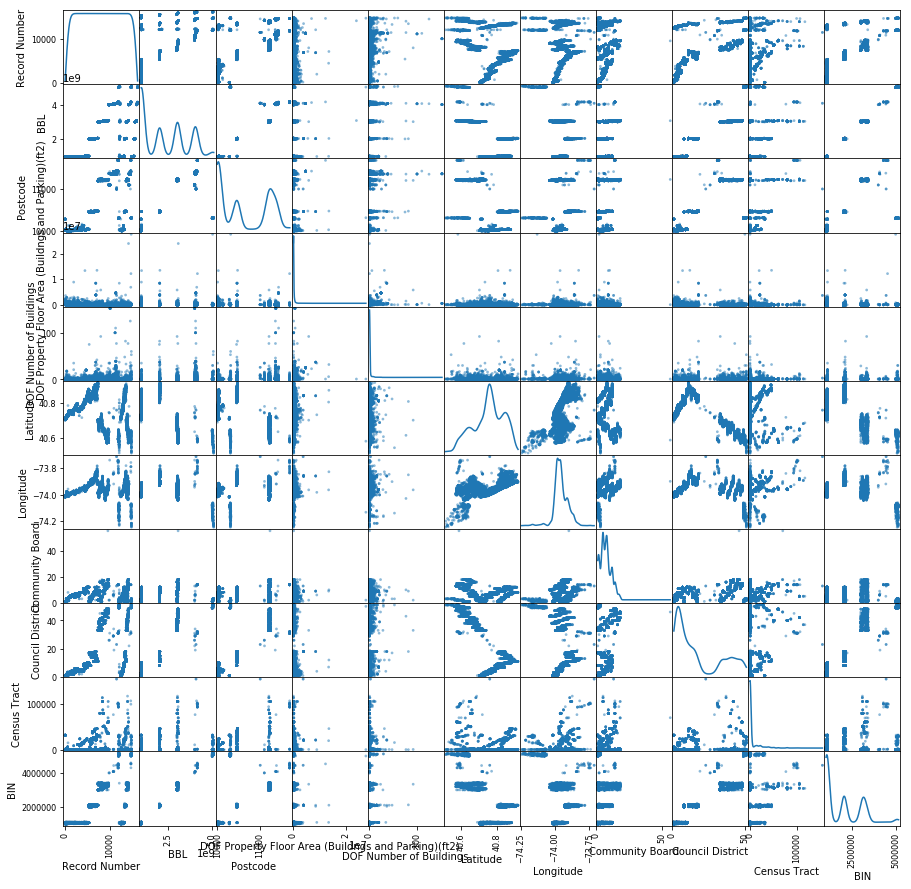

In [24]:
sfig = pd.scatter_matrix(energy, s=30, figsize=(15, 15), diagonal='kde')

Figure 1. Scatter matrix of all variables in the energy dataframe against each other including themselves. The diagonal if filled with a smooth histogram since plotting a variable against itself does not give any information. This kind of plot helps figure out the correlation between variables.

# data cleaning and aggregation

In [25]:
cols_to_drop_energy = [i for i in energy.columns.values if i != 'BBL' and i != 'Site EUI(kBtu/ft2)' 
                       and i != 'Reported Property Floor Area (Building(s)) (ft²)']
energy.drop(cols_to_drop_energy, axis=1, inplace=True)

In [26]:
cols_to_drop_bsize = [i for i in building_size.columns.values if i != 'BBL' and i != 'UnitsTotal' and i != 'UnitsRes'
                       and i != 'YearBuilt' and i != 'geometry']
building_size.drop(cols_to_drop_bsize, axis=1, inplace=True)

In [27]:
energy.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²)
0,1.000410e+09,NaN,918919
1,4.021460e+09,NaN,NaN
2,2.027620e+09,NaN,64200
3,1.006700e+09,NaN,NaN
4,2.048300e+09,NaN,50000


In [28]:
building_size.head()

,UnitsRes,UnitsTotal,YearBuilt,BBL,geometry
0,16,18,1920,1.015450e+09,"POLYGON ((997277.2344360352 221816.0936279297,..."
1,50,50,1914,1.007238e+09,"POLYGON ((984164.5626220703 211846.0704345703,..."
2,10,10,1910,1.016800e+09,"POLYGON ((1000742.195800781 227910.6640014648,..."
3,29,32,1928,1.013850e+09,"POLYGON ((994007.6885986328 219880.4284057617,..."
4,26,26,1900,1.011970e+09,"POLYGON ((992273.6849975586 224863.4904174805,..."


/anaconda2/envs/py36_geopandas/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pandas.scatter_matrix is deprecated, use pandas.plotting.scatter_matrix instead
  """Entry point for launching an IPython kernel.


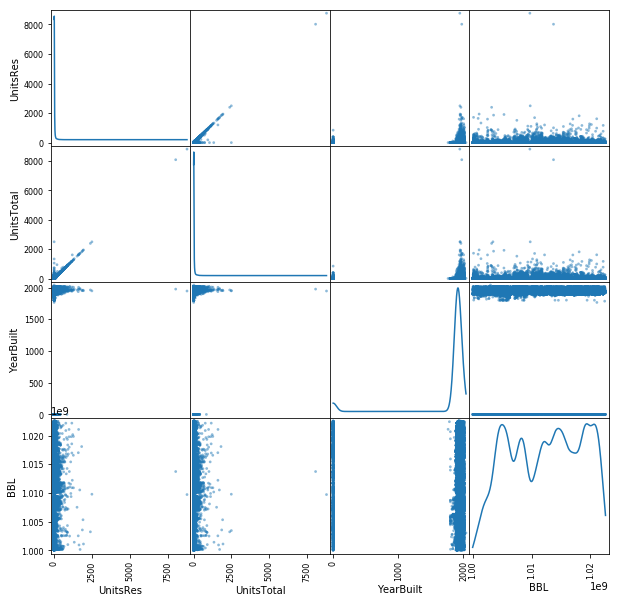

In [30]:
sfig = pd.scatter_matrix(building_size, s=30, figsize=(10, 10), diagonal='kde')

Figure 2. Scatter matrix of the variables left in the building_size geo dataframe against each other including themselves. The diagonal if filled with a smooth histogram since plotting a variable against itself does not give any information. Since we can see that all variables (except the geometry variable) are plotted, that means they are all numerical variables.

# converting the relevant columns to numeric values and throwing away spurious entries

In [43]:
energy['Reported Property Floor Area (Building(s)) (ft²)'] = pd.to_numeric(energy['Reported Property Floor Area (Building(s)) (ft²)'], errors='coerc')

In [48]:
energy['Site EUI(kBtu/ft2)'] = pd.to_numeric(energy['Site EUI(kBtu/ft2)'], errors='coerc')

In [49]:
energy['Site EUI(kBtu/ft2)'][:10]

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
5   NaN
6   NaN
7   NaN
8   NaN
9   NaN
Name: Site EUI(kBtu/ft2), dtype: float64

In [50]:
energy['Reported Property Floor Area (Building(s)) (ft²)'][:10]

0    918919.0
1         NaN
2     64200.0
3         NaN
4     50000.0
5     61800.0
6    102198.0
7     46620.0
8         NaN
9     54029.0
Name: Reported Property Floor Area (Building(s)) (ft²), dtype: float64

In [51]:
energy['BBL'][:10]

0    1.000410e+09
1    4.021460e+09
2    2.027620e+09
3    1.006700e+09
4    2.048300e+09
5    2.006120e+09
6    3.050770e+09
7    3.065710e+09
8    4.004490e+09
9    3.072240e+09
Name: BBL, dtype: float64

In [53]:
building_size['UnitsRes'][:10]

0    16
1    50
2    10
3    29
4    26
5     2
6     0
7     0
8    30
9    10
Name: UnitsRes, dtype: int64

In [54]:
building_size['UnitsTotal'][:10]

0    18
1    50
2    10
3    32
4    26
5     3
6     8
7     2
8    30
9    10
Name: UnitsTotal, dtype: int64

In [55]:
building_size['YearBuilt'][:10]

0    1920
1    1914
2    1910
3    1928
4    1900
5    1910
6    1920
7    1915
8    1915
9    1900
Name: YearBuilt, dtype: int64

In [56]:
building_size['BBL'][:10]

0    1.015450e+09
1    1.007238e+09
2    1.016800e+09
3    1.013850e+09
4    1.011970e+09
5    1.002360e+09
6    1.008370e+09
7    1.001960e+09
8    1.022240e+09
9    1.011270e+09
Name: BBL, dtype: float64

In [57]:
##check that your conversion worked: e.g.
print ("number of missing energy observations:", np.isnan(energy['Site EUI(kBtu/ft2)'].astype(float)).sum())

number of missing energy observations: 4623


In [58]:
print ("fraction of missing energy observations: %.2f"%(np.isnan(energy['Site EUI(kBtu/ft2)'].astype(float)).sum() /
      len(energy['Site EUI(kBtu/ft2)'])))

fraction of missing energy observations: 0.29


# merge the 2 datasets

In [98]:
bblnrgdataGPD = building_size.merge(energy, right_on="BBL", left_on="BBL")

In [99]:
bblnrgdataGPD.head()

,UnitsRes,UnitsTotal,YearBuilt,BBL,geometry,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²)
0,50,50,1914,1.007238e+09,"POLYGON ((984164.5626220703 211846.0704345703,...",68.7,95844.0
1,29,32,1928,1.013850e+09,"POLYGON ((994007.6885986328 219880.4284057617,...",87.4,206989.0
2,72,72,1923,1.021740e+09,"POLYGON ((1004080.155029297 252930.9956054688,...",140.4,52920.0
3,107,108,1931,1.008830e+09,"POLYGON ((989337.639831543 209686.7838134766, ...",96.5,98359.0
4,134,138,1910,1.008570e+09,"POLYGON ((988035.3540039062 210290.9854125977,...",36.4,154000.0


In [100]:
bblnrgdata = energy.merge(building_size, right_on="BBL", left_on="BBL")

In [101]:
bblnrgdata.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),UnitsRes,UnitsTotal,YearBuilt,geometry
0,1.006700e+09,NaN,NaN,0,1,1987,"POLYGON ((982544.9470214844 212642.966796875, ..."
1,1.004370e+09,NaN,NaN,0,4,1920,"POLYGON ((988632.9398193359 204610.9329833984,..."
2,1.013110e+09,125.4,330000.0,0,56,1977,"POLYGON ((993141.1744384766 216172.3948364258,..."
3,1.009220e+09,NaN,NaN,148,148,1963,"POLYGON ((989369.5852050781 206338.7576293945,..."
4,1.007400e+09,NaN,68329.0,0,1,1920,"POLYGON ((983418.6008300781 209632.8702392578,..."


In [102]:
bblnrgdata.drop('geometry', axis=1, inplace=True)

In [103]:
bblnrgdata.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),UnitsRes,UnitsTotal,YearBuilt
0,1.006700e+09,NaN,NaN,0,1,1987
1,1.004370e+09,NaN,NaN,0,4,1920
2,1.013110e+09,125.4,330000.0,0,56,1977
3,1.009220e+09,NaN,NaN,148,148,1963
4,1.007400e+09,NaN,68329.0,0,1,1920


# Plot the data as a choropleth for the 2 quantities of interest: number of units and energy consumed energy

In [104]:
bblnrgdataGPD.dropna(axis=0, inplace=True, subset=['Reported Property Floor Area (Building(s)) (ft²)', 'Site EUI(kBtu/ft2)'])

In [105]:
bblnrgdataGPD.head()

,UnitsRes,UnitsTotal,YearBuilt,BBL,geometry,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²)
0,50,50,1914,1.007238e+09,"POLYGON ((984164.5626220703 211846.0704345703,...",68.7,95844.0
1,29,32,1928,1.013850e+09,"POLYGON ((994007.6885986328 219880.4284057617,...",87.4,206989.0
2,72,72,1923,1.021740e+09,"POLYGON ((1004080.155029297 252930.9956054688,...",140.4,52920.0
3,107,108,1931,1.008830e+09,"POLYGON ((989337.639831543 209686.7838134766, ...",96.5,98359.0
4,134,138,1910,1.008570e+09,"POLYGON ((988035.3540039062 210290.9854125977,...",36.4,154000.0


In [106]:
bblnrgdataGPD['logarea'] = np.log(bblnrgdataGPD['Reported Property Floor Area (Building(s)) (ft²)'])
bblnrgdataGPD['lognrg'] = np.log(bblnrgdataGPD['Site EUI(kBtu/ft2)'])

/anaconda2/envs/py36_geopandas/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


In [109]:
bblnrgdataGPD.head()

,UnitsRes,UnitsTotal,YearBuilt,BBL,geometry,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),logarea,lognrg
0,50,50,1914,1.007238e+09,"POLYGON ((984164.5626220703 211846.0704345703,...",68.7,95844.0,11.470477,4.229749
1,29,32,1928,1.013850e+09,"POLYGON ((994007.6885986328 219880.4284057617,...",87.4,206989.0,12.240421,4.470495
2,72,72,1923,1.021740e+09,"POLYGON ((1004080.155029297 252930.9956054688,...",140.4,52920.0,10.876537,4.944495
3,107,108,1931,1.008830e+09,"POLYGON ((989337.639831543 209686.7838134766, ...",96.5,98359.0,11.496379,4.569543
4,134,138,1910,1.008570e+09,"POLYGON ((988035.3540039062 210290.9854125977,...",36.4,154000.0,11.944708,3.594569


(977413.3531738281, 1011284.1882080078, 191684.49734802247, 261826.39004211425)

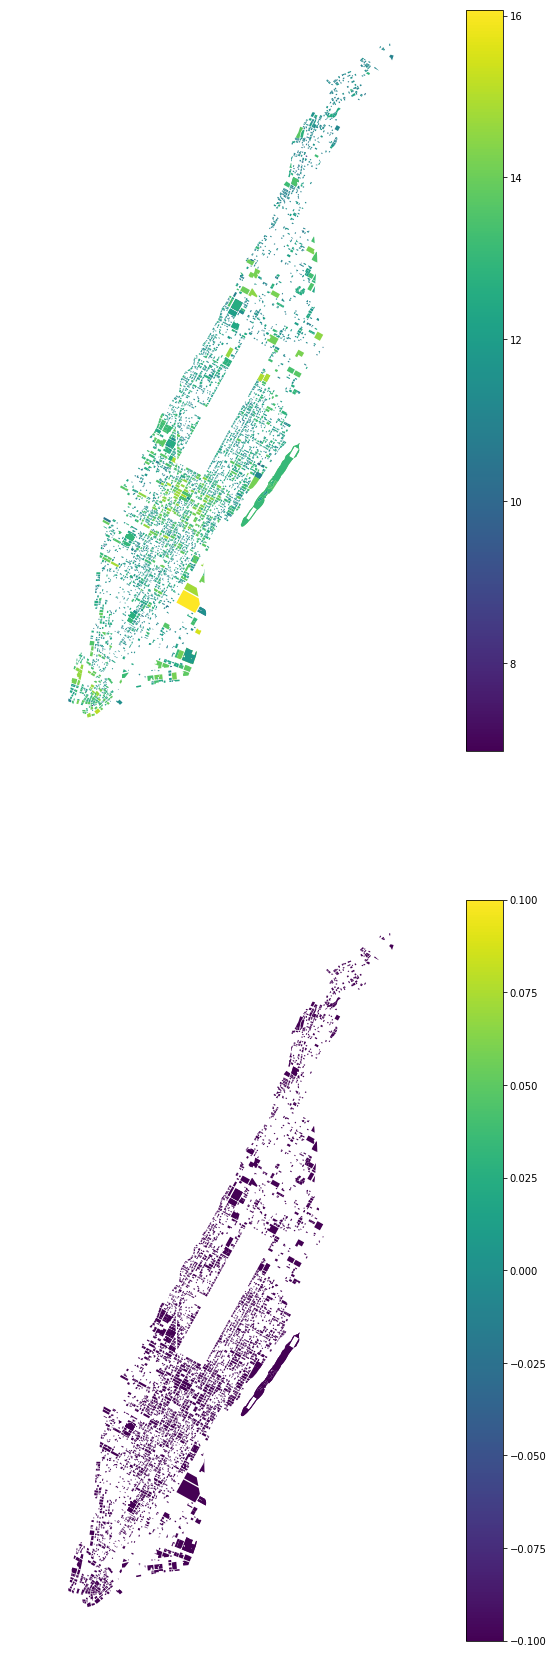

In [110]:
fig = pl.figure(figsize=(20,30))
ax = fig.add_subplot(211)
bblnrgdataGPD.plot("logarea", ax=ax, cmap="viridis", legend=True)
ax.axis('off')

ax = fig.add_subplot(212)
bblnrgdataGPD.plot("lognrg", ax=ax, cmap="viridis", legend=True)
ax.axis('off')

Figure 3. The top figure shows the Reported Property Floor Area in Manhattan in a logarithmic scale. The bottom figure shows the Site EUI(kBtu/ft2) (energy consumed per ft2) in Manhattan also in a logarithmic scale. In order to get these values, the rows containing NaN values were dropped first to prevent getting infinite values when calculating the logarithm

# feature engineering

In [111]:
bblnrgdata.dropna(axis=0, inplace=True, subset=['Reported Property Floor Area (Building(s)) (ft²)', 'Site EUI(kBtu/ft2)'])

In [114]:
bblnrgdata['nrg'] = bblnrgdata[\
    'Reported Property Floor Area (Building(s)) (ft²)'].astype(float) *\
                bblnrgdata['Site EUI(kBtu/ft2)'].astype(float)

Text(0, 0.5, 'Number of units in building')

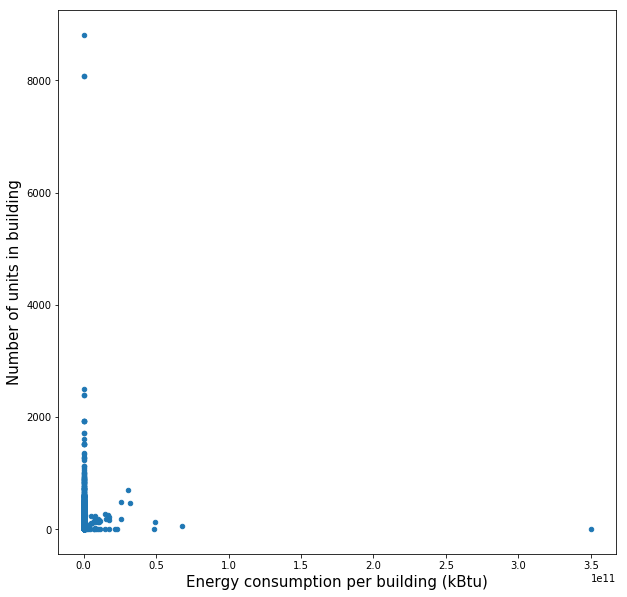

In [123]:
bblnrgdata.plot.scatter(x='nrg', y='UnitsTotal', figsize=(10,10))
pl.xlabel('Energy consumption per building (kBtu)', fontsize=15)
pl.ylabel('Number of units in building', fontsize=15)

Figure 4. Number of units in building vs energy consumption per building measured in kBtu. Since there are some clear outliers in both axis, we need to zoom in to take a better look at the data.

(0, 1000)

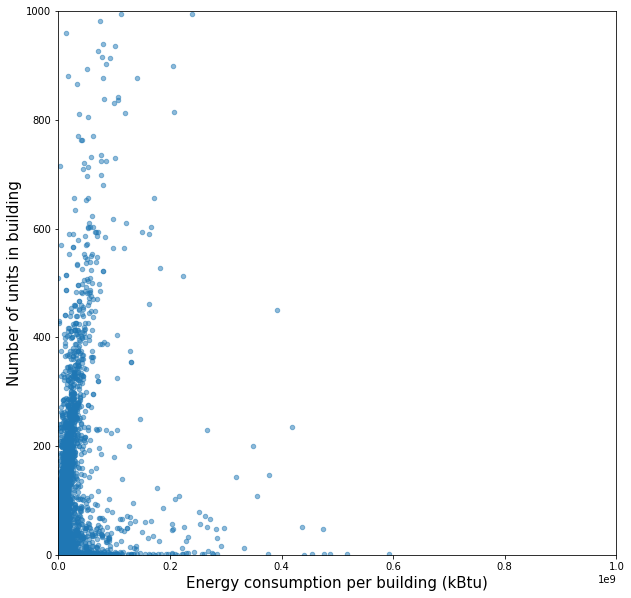

In [142]:
bblnrgdata.plot.scatter(x='nrg', y='UnitsTotal', figsize=(10,10), alpha=0.5)
pl.xlabel('Energy consumption per building (kBtu)', fontsize=15)
pl.ylabel('Number of units in building', fontsize=15)
pl.xlim(0,1000000000)
pl.ylim(0,1000)

Figure 5. Number of units in building vs energy consumption per building measured in kBtu, removing the maximum value of energy since it's an outlier, and also getting rid of some values in the y axis trying to see if there is a clear trend. We can see that the bulk of the data in the x axis is located between 0 and $0.6e^{9}$

In [152]:
bblnrgdata['lognrg'] = np.log10(bblnrgdata['nrg'])

/anaconda2/envs/py36_geopandas/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


In [153]:
bblnrgdata['logunit'] = np.log10(bblnrgdata['UnitsTotal'])

/anaconda2/envs/py36_geopandas/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


Text(0, 0.5, 'Number of units in building (log)')

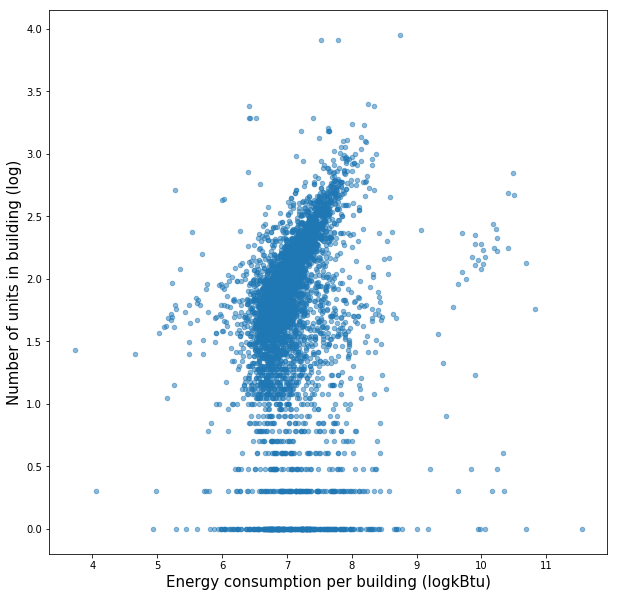

In [154]:
bblnrgdata.plot.scatter(x='lognrg', y='logunit', figsize=(10,10), alpha=0.5)
pl.xlabel('Energy consumption per building (logkBtu)', fontsize=15)
pl.ylabel('Number of units in building (log)', fontsize=15)

Figure 6. log 10 Number of units in building vs energy consumption per building measured in log10 kBtu.

Text(0.5, 0, 'Number of units in building (log)')

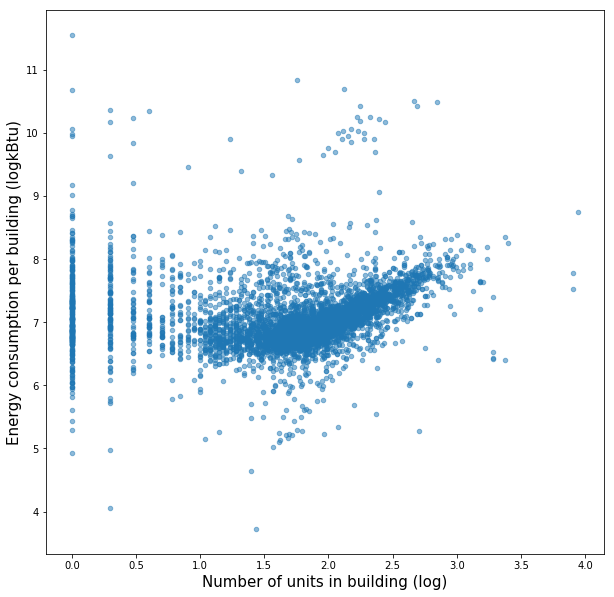

In [155]:
bblnrgdata.plot.scatter(x='logunit', y='lognrg', figsize=(10,10), alpha=0.5)
pl.ylabel('Energy consumption per building (logkBtu)', fontsize=15)
pl.xlabel('Number of units in building (log)', fontsize=15)

Figure 7. Wnergy consumption per building measured in log10 kBtu vs log 10 number of units in building.